In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 622ms/step - loss: 0.3598
Average validation loss: 0.6825240254402161
4/4 [==============================] - 7s 636ms/step - loss: 0.3598 - val_loss: 0.6825
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 629ms/step - loss: 0.2702 - val_loss: 0.6825
Average validation loss: 0.4699818193912506
4/4 [==============================] - 9s 644ms/step - loss: 0.2702 - val_loss: 0.5763
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 12s 638ms/step - loss: 0.2095 - val_loss: 0.5763
Average validation loss: 0.33560431003570557
4/4 [==============================] - 12s 655ms/step - loss: 0.2095 - val_loss: 0.4960
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 747ms/step - loss: 0.0180
Average validation loss: 7.788058792357333e-05
8/8 [==============================] - 6s 763ms/step - loss: 0.0180 - val_loss: 7.7881e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 772ms/step - loss: 0.0174 - val_loss: 7.7881e-05
Average validation loss: 2.5370418825332308e-05
8/8 [==============================] - 12s 786ms/step - loss: 0.0174 - val_loss: 5.1626e-05
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 19s 756ms/step - loss: 0.0170 - val_loss: 5.1626e-05
Average validation loss: 0.001994037418626249
8/8 [==============================] - 19s 768ms/step - loss: 0.0170 - val_loss: 6.9910e-04
Epoch 4/10

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 739ms/step - loss: 0.0240
Average validation loss: 0.10268280460013524
12/12 [==============================] - 9s 754ms/step - loss: 0.0240 - val_loss: 0.1027
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 750ms/step - loss: 0.0214 - val_loss: 0.1027
Average validation loss: 0.0675141126557719
12/12 [==============================] - 18s 764ms/step - loss: 0.0214 - val_loss: 0.0851
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 27s 758ms/step - loss: 0.0204 - val_loss: 0.0851
Average validation loss: 0.15516265240379767
12/12 [==============================] - 28s 771ms/step - loss: 0.0204 - val_loss: 0.1085
Epoch 4/10
12/12 [=======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 743ms/step - loss: 0.0145
Average validation loss: 0.08226169484873935
16/16 [==============================] - 12s 757ms/step - loss: 0.0145 - val_loss: 0.0823
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 747ms/step - loss: 0.0140 - val_loss: 0.0823
Average validation loss: 0.024992796872538747
16/16 [==============================] - 24s 760ms/step - loss: 0.0140 - val_loss: 0.0536
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 734ms/step - loss: 0.0142 - val_loss: 0.0536
Average validation loss: 0.019831679295748472
16/16 [==============================] - 36s 747ms/step - loss: 0.0142 - val_loss: 0.0424
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 724ms/step - loss: 0.0112
Average validation loss: 0.06634611716490327
20/20 [==============================] - 15s 738ms/step - loss: 0.0112 - val_loss: 0.0663
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 723ms/step - loss: 0.0103 - val_loss: 0.0663
Average validation loss: 0.09594692482444316
20/20 [==============================] - 30s 735ms/step - loss: 0.0103 - val_loss: 0.0811
Epoch 3/10
20/20 [==============================] - 44s 721ms/step - loss: 0.0098 - val_loss: 0.0811
Average validation loss: 0.03911750664410647
20/20 [==============================] - 44s 733ms/step - loss: 0.0098 - val_loss: 0.0671
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_25.pth'.
Epoch 4/10
20/20 [====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 740ms/step - loss: 0.0108
Average validation loss: 0.05063307968278726
24/24 [==============================] - 18s 752ms/step - loss: 0.0108 - val_loss: 0.0506
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 720ms/step - loss: 0.0105 - val_loss: 0.0506
Average validation loss: 0.05744198523461819
24/24 [==============================] - 36s 732ms/step - loss: 0.0105 - val_loss: 0.0540
Epoch 3/10
24/24 [==============================] - 53s 716ms/step - loss: 0.0096 - val_loss: 0.0540
Average validation loss: 0.019861311186105013
24/24 [==============================] - 53s 729ms/step - loss: 0.0096 - val_loss: 0.0426
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_30.pth'.
Epoch 4/10
24/24 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 721ms/step - loss: 0.0176
Average validation loss: 0.054280507005751134
40/40 [==============================] - 29s 734ms/step - loss: 0.0176 - val_loss: 0.0543
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 722ms/step - loss: 0.0158 - val_loss: 0.0543
Average validation loss: 0.024275818653404713
40/40 [==============================] - 59s 735ms/step - loss: 0.0158 - val_loss: 0.0393
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 728ms/step - loss: 0.0147 - val_loss: 0.0393
Average validation loss: 0.028582523204386236
40/40 [==============================] - 89s 742ms/step - loss: 0.0147 - val_loss: 0.0357
Epoch 4/10
40/40 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 735ms/step - loss: 0.0125
Average validation loss: 0.02406025472737383
48/48 [==============================] - 36s 748ms/step - loss: 0.0125 - val_loss: 0.0241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 731ms/step - loss: 0.0104 - val_loss: 0.0241
Average validation loss: 0.018967920751795948
48/48 [==============================] - 72s 743ms/step - loss: 0.0104 - val_loss: 0.0215
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 723ms/step - loss: 0.0091 - val_loss: 0.0215
Average validation loss: 0.04559047220122162
48/48 [==============================] - 107s 737ms/step - loss: 0.0091 - val_loss: 0.0295
Epoch 4/10
48/48 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 735ms/step - loss: 0.0113
Average validation loss: 0.013707932063880435
56/56 [==============================] - 42s 747ms/step - loss: 0.0113 - val_loss: 0.0137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 83s 734ms/step - loss: 0.0088 - val_loss: 0.0137
Average validation loss: 0.02693349779423723
56/56 [==============================] - 84s 747ms/step - loss: 0.0088 - val_loss: 0.0203
Epoch 3/10
56/56 [==============================] - 124s 721ms/step - loss: 0.0076 - val_loss: 0.0203
Average validation loss: 0.1777111753107148
56/56 [==============================] - 125s 733ms/step - loss: 0.0076 - val_loss: 0.0728
Epoch 4/10
56/56 [==============================] - 165s 718ms/step - loss: 0.0067 - val_loss: 0.0728
Average validation loss: 0.09532420230043977
56/56 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 727ms/step - loss: 0.0150
Average validation loss: 0.13334334415094418
64/64 [==============================] - 47s 740ms/step - loss: 0.0150 - val_loss: 0.1333
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 720ms/step - loss: 0.0133 - val_loss: 0.1333
Average validation loss: 0.19878749502822757
64/64 [==============================] - 94s 732ms/step - loss: 0.0133 - val_loss: 0.1661
Epoch 3/10
64/64 [==============================] - 141s 732ms/step - loss: 0.0149 - val_loss: 0.1661
Average validation loss: 0.023836734185408652
64/64 [==============================] - 142s 744ms/step - loss: 0.0149 - val_loss: 0.1187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_80.pth'.
Epoch 4/10
64/64 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 724ms/step - loss: 0.0080
Average validation loss: 0.011273392372661166
72/72 [==============================] - 53s 736ms/step - loss: 0.0080 - val_loss: 0.0113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 723ms/step - loss: 0.0061 - val_loss: 0.0113
Average validation loss: 0.007653980179586344
72/72 [==============================] - 106s 736ms/step - loss: 0.0061 - val_loss: 0.0095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 721ms/step - loss: 0.0051 - val_loss: 0.0095
Average validation loss: 0.00944415637705889
72/72 [==============================] - 159s 733ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 4/10
72/72

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 720ms/step - loss: 0.0063
Average validation loss: 0.07840782441198826
80/80 [==============================] - 59s 732ms/step - loss: 0.0063 - val_loss: 0.0784
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 719ms/step - loss: 0.0053 - val_loss: 0.0784
Average validation loss: 0.008986110438127071
80/80 [==============================] - 117s 731ms/step - loss: 0.0053 - val_loss: 0.0437
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 719ms/step - loss: 0.0049 - val_loss: 0.0437
Average validation loss: 0.029270992567762732
80/80 [==============================] - 176s 731ms/step - loss: 0.0049 - val_loss: 0.0389
Epoch 4/10
80/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 719ms/step - loss: 0.0102
Average validation loss: 0.019674657358943175
96/96 [==============================] - 70s 732ms/step - loss: 0.0102 - val_loss: 0.0197
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 722ms/step - loss: 0.0081 - val_loss: 0.0197
Average validation loss: 0.025128492639244843
96/96 [==============================] - 141s 735ms/step - loss: 0.0081 - val_loss: 0.0224
Epoch 3/10
96/96 [==============================] - 210s 718ms/step - loss: 0.0068 - val_loss: 0.0224
Average validation loss: 0.02201296248919486
96/96 [==============================] - 211s 731ms/step - loss: 0.0068 - val_loss: 0.0223
Epoch 4/10
96/96 [==============================] - 280s 719ms/step - loss: 0.0060 - val_loss: 0.0223
Average validation loss: 0.022891423702579534
96/96 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 717ms/step - loss: 0.0074
Average validation loss: 0.007249590770031015
120/120 [==============================] - 88s 730ms/step - loss: 0.0074 - val_loss: 0.0072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 717ms/step - loss: 0.0060 - val_loss: 0.0072
Average validation loss: 0.0058054748661864625
120/120 [==============================] - 175s 729ms/step - loss: 0.0060 - val_loss: 0.0065
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 262s 719ms/step - loss: 0.0051 - val_loss: 0.0065
Average validation loss: 0.007461973069621308
120/120 [==============================] - 263s 732ms/step - loss: 0.0051 - val_loss: 0.0068


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 722ms/step - loss: 0.0067
Average validation loss: 0.0075987223795266345
144/144 [==============================] - 106s 734ms/step - loss: 0.0067 - val_loss: 0.0076
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 719ms/step - loss: 0.0054 - val_loss: 0.0076
Average validation loss: 0.008451599824537779
144/144 [==============================] - 211s 732ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 3/10
144/144 [==============================] - 315s 721ms/step - loss: 0.0046 - val_loss: 0.0080
Average validation loss: 0.008033025877356041
144/144 [==============================] - 317s 733ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 4/10
144/144 [==============================] - 420s 719ms/step - loss: 0.0042 - val_loss: 0.0080
Average validation loss: 0.009916458734538636

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 136s 852ms/step - loss: 0.0056
Average validation loss: 0.006610939616222557
160/160 [==============================] - 139s 867ms/step - loss: 0.0056 - val_loss: 0.0066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 284s 907ms/step - loss: 0.0042 - val_loss: 0.0066
Average validation loss: 0.005182708123160751
160/160 [==============================] - 286s 922ms/step - loss: 0.0042 - val_loss: 0.0059
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 418s 820ms/step - loss: 0.0036 - val_loss: 0.0059
Average validation loss: 0.006358618734448385
160/160 [==============================] - 420s 833ms/step - loss: 0.0036 - val_loss: 0.0061

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0085
Average validation loss: 0.009327421172347385
200/200 [==============================] - 146s 732ms/step - loss: 0.0085 - val_loss: 0.0093
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 720ms/step - loss: 0.0066 - val_loss: 0.0093
Average validation loss: 0.008992517931567754
200/200 [==============================] - 293s 732ms/step - loss: 0.0066 - val_loss: 0.0092
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 437s 721ms/step - loss: 0.0058 - val_loss: 0.0092
Average validation loss: 0.006419103531850823
200/200 [==============================] - 440s 733ms/step - loss: 0.0058 - val_loss: 0.0082

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:55 - loss: 0.0011

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 720ms/step - loss: 0.0053
Average validation loss: 0.01660362368832769
240/240 [==============================] - 176s 733ms/step - loss: 0.0053 - val_loss: 0.0166
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 722ms/step - loss: 0.0045 - val_loss: 0.0166
Average validation loss: 0.00886224092488798
240/240 [==============================] - 352s 734ms/step - loss: 0.0045 - val_loss: 0.0127
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_40\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 526s 723ms/step - loss: 0.0041 - val_loss: 0.0127
Average validation loss: 0.017153673324776263
240/240 [==============================] - 528s 735ms/step - loss: 0.0041 - val_loss: 0.0142
E

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10244154162562331, 0.09599230980347215, 0.11675692717273124, 0.08075017730833252, 0.07141428748341809, 0.06074506015441154, 0.05098820071732977, 0.07001220323048112, 0.05120235480757018, 0.08124942484326622, 0.019970122907835005, 0.010605643686040367, 0.009291248526190643, 0.005495864900124414, 0.005236684826548382, 0.004796301082227994, 0.00705605340939608, 0.009629612381202884]
std_val_losses =  [0.16715627198313907, 0.0953250339013115, 0.18581460330351215, 0.07376503578698812, 0.06113900339745758, 0.09609275515967693, 0.054395132803386606, 0.08605011347555057, 0.08534311079128193, 0.24185170073016876, 0.031178634710708426, 0.011675368239476985, 0.010308653028847157, 0.0024131945707350517, 0.0026932773428745443, 0.0032413529545260154, 0.004484662037926053, 0.010279936088340326]


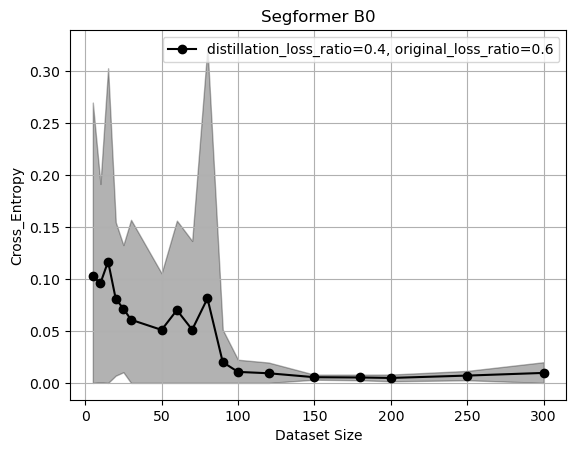

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()